In [1]:
import pyreadstat
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# a function to compute deferral rates and make a 2X2 table

def make_table(df):
    first=df.query("first_time == 1")
    repeat=df.query("first_time == 0")
    print(len(repeat))
    
    #create a dict
    table={}
    table['-']=['Female', 'Male', 'All']

        #first time
    female=(len(first.loc[(first.DONOR_GENDER == 'F') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.DONOR_GENDER == 'F')]))*100
    male=(len(first.loc[(first.DONOR_GENDER == 'M') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.DONOR_GENDER == 'M')]))*100
    alls=(len(first.loc[(first.OUTCOME_TYPE=='low hgb')])/len(first))*100
    table['First Time']=[female, male, alls]

        #repeat
    female=(len(repeat.loc[(repeat.DONOR_GENDER == 'F') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.DONOR_GENDER == 'F')]))*100
    male=(len(repeat.loc[(repeat.DONOR_GENDER == 'M') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.DONOR_GENDER == 'M')]))*100
    alls=(len(repeat.loc[(repeat.OUTCOME_TYPE=='low hgb')])/len(repeat))*100
    table['Repeat']=[female, male, alls]
    
    print(len(repeat.loc[(repeat.DONOR_GENDER == 'M')]))
    
        #all 
    female=(len(df.loc[(df.DONOR_GENDER == 'F') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.DONOR_GENDER == 'F')]))*100
    male=(len(df.loc[(df.DONOR_GENDER == 'M') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.DONOR_GENDER == 'M')]))*100
    alls=(len(df.loc[(df.OUTCOME_TYPE=='low hgb')])/len(df))*100
    table['All']=[female, male, alls]
    table=pd.DataFrame(table)
    
    return table
    


In [3]:
df=pd.read_csv("../1_data/private/VitalantData.csv") #load merged data

In [4]:
#using only donations table linked to med_quest for hgb values

df['first_time']=np.where(df.ACTIVE_DONOR_TYPE=='First Time', 1,0) #add first time col

#check if hgb value is below threshold
df.loc[(df['HGB_value']<13.0) & (df['DONOR_GENDER'] == "M"), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['HGB_value']<12.5) & (df['DONOR_GENDER'] == "F"), 'OUTCOME_TYPE'] = 'low hgb'

#make table
table=make_table(df)
print(table)
df['OUTCOME_TYPE'].value_counts()


4640364
2063360
        -  First Time    Repeat       All
0  Female    6.697233  7.856918  7.620287
1    Male    0.800060  1.938004  1.727404
2     All    4.250087  5.225043  5.034224


low hgb    290454
Name: OUTCOME_TYPE, dtype: int64

In [5]:
df.ACTIVE_DONOR_TYPE.value_counts()

Active        4069442
First Time    1129224
Reengaged      570922
Name: ACTIVE_DONOR_TYPE, dtype: int64

In [6]:
def_columns=['DEFERRAL_EVENT', 'DEFERRAL_INFORMATION',
       'DEFERRAL_CREATE_DATE', 'DEFERRAL_START_DATE', 'DEFERRAL_STOP_DATE',
       'DEF_INVALDATION_DATE', 'DEFERRAL', 'DEFERRAL_DESCRIPTION',
       'DEFERRAL_VALID_CODE', 'DEFERRAL_DURATION', 'DURATION_MODIF_TYPE',
       'ALLOW_DISTRIBUTION', 'DEFERRAL_GROUP']

df['def_isna']=df[def_columns].isnull().apply(lambda x: all(x), axis=1) 

len(df.loc[(df.OUTCOME_TYPE=='low hgb') & (df.def_isna==True)]) #no deferral info

81486

In [7]:
# check donations with mutiple deferrals
#keep one with longest deferral period

df["Visit_Date"] = pd.to_datetime(df['DON_DATE_KEY'], format='%Y%m%d') #convert to datetime object
df['DEFERRAL_STOP_DATE'] = pd.to_datetime(df['DEFERRAL_STOP_DATE'], errors='coerce')

# Sort the DataFrame by 'key' and 'date' in descending order
df = df.sort_values(by=['DONOR_KEY', 'DON_DATE_KEY', 'DEFERRAL_STOP_DATE'], ascending=[True, True, False])

df = df.drop_duplicates(subset=['DONOR_KEY', 'DON_DATE_KEY'], keep='first')


In [8]:
#deferrals where low hgbval and def group dont agree
df['OUTCOME_TYPE']=np.where((df.OUTCOME_TYPE=='low hgb') & (df.def_isna==False) & (df.DEFERRAL_GROUP!='Low Hemoglobin'), 'other deferral', df.OUTCOME_TYPE)
df.drop(df[(df.OUTCOME_TYPE=='low hgb') & (df.PHLEBOTOMY_STATUS=='Successful Phlebotomy')].index, inplace =True)#drop
df.OUTCOME_TYPE.value_counts()

low hgb           283974
other deferral      2207
Name: OUTCOME_TYPE, dtype: int64

In [9]:
#classify visits into completed and other deferrals

df['OUTCOME_TYPE'] = np.where((df.PHLEBOTOMY_STATUS=='Successful Phlebotomy'), 'completed', df.OUTCOME_TYPE)

df['OUTCOME_TYPE']= np.where((df['OUTCOME_TYPE'].isna()) & (df.def_isna==False), 'other deferral', df.OUTCOME_TYPE)

df['OUTCOME_TYPE'].fillna("No Draw", inplace=True)

df.OUTCOME_TYPE.value_counts()

completed         4735203
No Draw            428228
low hgb            283974
other deferral     265821
Name: OUTCOME_TYPE, dtype: int64

In [10]:
#add censoring 

df.sort_values(by=['DONOR_KEY', 'DON_DATE_KEY'], axis = 0, inplace=True) #check all vists are sorted

#add CENSORED column (indicates whether row is right censored) 0-censored, 1-notcensored (does not make sense but is consistent with rest of code)
df['CENSORED']=np.where(df['DONOR_KEY'] == df['DONOR_KEY'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-10-31

df["Visit_Date"] = pd.to_datetime(df['DON_DATE_KEY'], format='%Y%m%d') #convert to datetime object

df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 10, 31)-df["Visit_Date"])/np.timedelta64(1, 'D'))


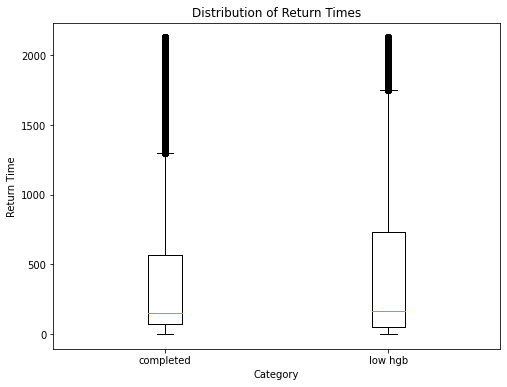

0


In [11]:
# Create a boxplot to see distribution of return times
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()

df_end=df.loc[df['time_to_return'] <0]
print(len(df_end))

In [12]:


df['DEFERRAL_STOP_DATE'] = pd.to_datetime(df['DEFERRAL_STOP_DATE'], errors='coerce')
df['DEFERRAL_START_DATE'] = pd.to_datetime(df['DEFERRAL_START_DATE'],  errors='coerce')

df['def_Year'] = df['DEFERRAL_STOP_DATE'].dt.year 

df['DEF_PERIOD']=(df['DEFERRAL_STOP_DATE'] - df['DEFERRAL_START_DATE'])/np.timedelta64(1, 'D')

#permanent deferrals: drop
df.drop(df[df['def_Year']>=2032].index, inplace=True)
df.drop(df[df['DEFERRAL_DURATION']==99999.0].index, inplace=True)

df.fillna(0, inplace=True)



In [13]:
#compute time_to_return with shifts for completed donation: subtract 56 days 
df['time_to_return_wo'] = df['time_to_return']
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'completed'), (df['time_to_return_wo'] - 56), df['time_to_return'])

#time for hgb deferrals (-1)
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'low hgb'), (df['time_to_return_wo'] - 1), df['time_to_return'])

#time for other deferrals (-def period)
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'other deferral') & (df['def_Year'] < 2023), (df['time_to_return_wo'] - df['DEF_PERIOD']), df['time_to_return'])
df['time_to_return'].isna().sum()

#df['time_to_return']=np.where((df['time_to_return'] < 0) & (df.OUTCOME_TYPE=='completed') , df['time_to_return_wo'], df['time_to_return'])

#drop individuals who returned before end of eligibility period
df.drop(df[(df.time_to_return<0)].index, inplace =True)


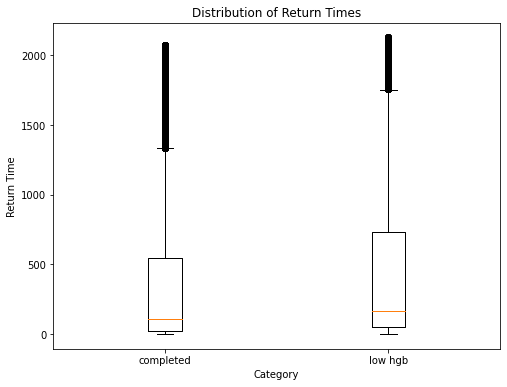

0


In [14]:
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()

df_end=df.loc[df['time_to_return'] <0]
pd.set_option('display.max_columns', 100)
print(len(df_end))


In [15]:
df.drop(df.loc[df.DRIVE_TYPE_FIXED_MOBILE=='UNKNOWN'].index, inplace =True)#drop

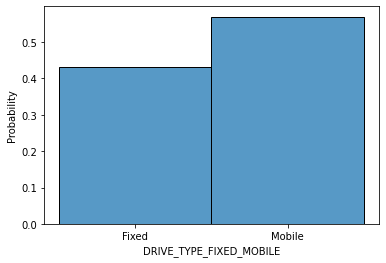

In [16]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1

sns.histplot(df, x="DRIVE_TYPE_FIXED_MOBILE", stat="probability")

df['Fixed_mobile'] = np.where(df["DRIVE_TYPE_FIXED_MOBILE"] == 'Fixed', 1, 0) #mobile is 0, fixed is 1
#sns.histplot(df, x="Fixed_mobile", stat="probability")

#create a column to indicate 
    #1. mobile then mobile - mm
    #2. mobile then fixed -mf
    #3. fixed then fixed - ff
    #4. fixed then mobile - fm

df["FIXED_NEXT"] = np.where((df['DONOR_KEY'] == df['DONOR_KEY'].shift(-1)), df['Fixed_mobile'].shift(-1), 10)
df.loc[((df['FIXED_NEXT']== 1) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FF'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MM'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FM'

df.loc[((df['FIXED_NEXT']==1) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MF'
df['fixed_mobile_pattern'].fillna('last', inplace=True)

#define competeing events
# competing events are - return to mobile, return to fixed
df['competing_events'] = np.where((df['fixed_mobile_pattern']=="MF")|(df['fixed_mobile_pattern']=="FF"), 1, 2)
df['competing_events'] = np.where((df['fixed_mobile_pattern']=="last"), 0, df['competing_events'])

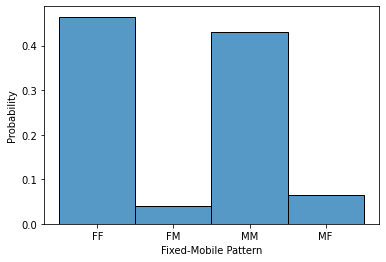

0.05813837106416765
0.04633264209735292
0.43069571085831737
0.5693042891416826


In [17]:
#Plot fixed pattern
df2 = df[df['fixed_mobile_pattern'] != 'last']
plt.figure()
g=sns.histplot(df2, x=df2["fixed_mobile_pattern"], stat="probability")
#plt.legend(title='Fixed-Mobile Pattern', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
plt.xlabel('Fixed-Mobile Pattern')
plt.show(g)

# the % of each resulting in hemoglobin deferral or other deferral

print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 1))])/len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 0))])/len(df.loc[(df['Fixed_mobile']==0)]))

print(len(df.loc[(df['Fixed_mobile']==1)])/len(df))
print(len(df.loc[(df['Fixed_mobile']==0)])/len(df))


In [18]:
#check if donor return to the same mobile ID

#for fixed only, for mobile only and overall

df.loc[(df.Fixed_mobile==0) & (df['COLLECTION_SITE_KEY'] == df['COLLECTION_SITE_KEY'].shift(-1)), 'return_to_same_ID_by_dn']= 'mm' #for mobile only
df.loc[(df.Fixed_mobile==1) & (df['COLLECTION_SITE_KEY'] == df['COLLECTION_SITE_KEY'].shift(-1)), 'return_to_same_ID_by_dn']= 'ff' #for fixed only
df.loc[(df['COLLECTION_SITE_KEY'] == df['COLLECTION_SITE_KEY'].shift(-1)), 'return_to_same_ID']= 1 #overall


In [19]:

#Categorize donor birth country
df['DONOR_BORN_IN_US'] = np.where(df['DONOR_COUNTRY_OF_BIRTH']=='UNITED STATES (INCLUDING HAWAII)', 1, 0)

#Born in north america / mexico / india / china - look into counts

#categorise donor education into - post secondary, secondary (high school), or less than secondary or refused 

df.loc[(df['DONOR_EDUCATION_DESC']=='SOME COLLEGE OR TECHNICAL SCHOOL' )| (df['DONOR_EDUCATION_DESC']=="BACHELOR'S DEGREE")| 
      (df['DONOR_EDUCATION_DESC']=="MASTER'S OR PROFESSIONAL DEGREE")| (df['DONOR_EDUCATION_DESC']=="ASSOCIATE'S DEGREE")|  
       (df['DONOR_EDUCATION_DESC']=="GRADUATE DEGREE, MASTER'S")|(df['DONOR_EDUCATION_DESC']=="GRADUATE DEGREE, DOCTORATE")|
      (df['DONOR_EDUCATION_DESC']=="GRADUATE DEGREE, PROFESSIONAL")| (df['DONOR_EDUCATION_DESC']=="GRADUATE DEGREE, OTHER"),
       'DONOR_EDU2']='Post_Secondary'

df.loc[(df['DONOR_EDUCATION_DESC']=='HIGH SCHOOL GRAD-DIPLOMA OR EQUIV')| (df['DONOR_EDUCATION_DESC']==
        'HIGH SCHOOL GRADUATE OR EQUIVALENT'),'DONOR_EDU2']='Secondary_High_School'

df.loc[(df['DONOR_EDUCATION_DESC']=='9th,10th,11th,12th GRADE-NO DIPLOMA' )| (df['DONOR_EDUCATION_DESC']=='8th GRADE OR LESS' )|
      (df['DONOR_EDUCATION_DESC']=='9TH, 10TH, 11TH, OR 12TH (NO DIPLOMA)' )| (df['DONOR_EDUCATION_DESC']=='8TH GRADE OR LESS'), 'DONOR_EDU2']='Less_than_secondary'

df.loc[(df['DONOR_EDUCATION_DESC']=='REFUSED') | (df['DONOR_EDUCATION_DESC']=='UNAVAILABLE' )| (df['DONOR_EDUCATION_DESC']=='UNKNOWN') |  (df['DONOR_EDUCATION_DESC']=='NOT AVAILABLE'), 'DONOR_EDU2']='UNAVAILABLE'

df['DONOR_EDU']=np.where(df.DONOR_AGE_AT_DONATION<=18, 'Currently in High School', df['DONOR_EDU2'])

In [20]:
#recode race
df.loc[df['RACE_ETHNICITY'] == 'White, NH', 'RACE_ETHNICITY'] = 'White'
df.loc[df['RACE_ETHNICITY'] == 'Black, NH', 'RACE_ETHNICITY'] = 'Black'
df.loc[df['RACE_ETHNICITY'] == 'Asian/Pacific Islander, NH', 'RACE_ETHNICITY'] = 'Asian'
df.loc[df['RACE_ETHNICITY'] == 'Native American/Alaskan, NH', 'RACE_ETHNICITY'] = 'Native_American'
df.loc[df['RACE_ETHNICITY'] == 'Other/Mixed, NH', 'RACE_ETHNICITY'] = 'Mixed_Other'
df.loc[df['RACE_ETHNICITY'] == 0, 'RACE_ETHNICITY'] = 'UNKNOWN'
df.loc[df['RACE_ETHNICITY'] == 'Missing/Unknown/Refused', 'RACE_ETHNICITY'] = 'UNKNOWN'

In [21]:
#recode AbO_RH

df.loc[df['DONOR_ABORH'] == 'UNKNOWN', 'DONOR_ABORH'] = 'UNK'
df.loc[df['DONOR_ABORH'] == 'A -', 'DONOR_ABORH'] = 'Aneg'
df.loc[df['DONOR_ABORH'] == 'A +', 'DONOR_ABORH'] = 'Apos'
df.loc[df['DONOR_ABORH'] == 'B -', 'DONOR_ABORH'] = 'Bneg'
df.loc[df['DONOR_ABORH'] == 'B +', 'DONOR_ABORH'] = 'Bpos'
df.loc[df['DONOR_ABORH'] == 'O -', 'DONOR_ABORH'] = 'Oneg'
df.loc[df['DONOR_ABORH'] == 'O +', 'DONOR_ABORH'] = 'Opos'
df.loc[df['DONOR_ABORH'] == 'AB-', 'DONOR_ABORH'] = 'ABneg'
df.loc[df['DONOR_ABORH'] == 'AB+', 'DONOR_ABORH'] = 'ABpos'

In [22]:
# add oppurtunities to donate in next 12 months - computed in 00_mobileID.ipynb and saved in csv file, mID_table
df_mID=pd.read_csv("../1_data/private/mID_table_V.csv")

df_mID["Visit_Date"] = df_mID["Visit_Date"].astype("datetime64") #convert to date time object

df['MobileID']=df['COLLECTION_SITE_KEY']

df=pd.merge(df, df_mID[['MobileID', 'Visit_Date', 'count_in_next_12_months']], how='left', on=["MobileID", "Visit_Date"])


In [23]:
df.loc[df.count_in_next_12_months==1, 'Opp_to_donate']="Annual"
df.loc[df.count_in_next_12_months==2, 'Opp_to_donate']="Bi_Annual"
df.loc[(df.count_in_next_12_months>=3) & (df.count_in_next_12_months<=6), 'Opp_to_donate']="3_6"
df.loc[(df.count_in_next_12_months>6) & (df.count_in_next_12_months<=12), 'Opp_to_donate']="7_12"
df.loc[(df.count_in_next_12_months>12), 'Opp_to_donate']="12_more"
df.Opp_to_donate.value_counts()

12_more      2800129
7_12          211535
3_6            98819
Annual         14590
Bi_Annual      13357
Name: Opp_to_donate, dtype: int64

In [30]:
df = df.sort_values(by=['DonorID', 'Visit_Date'])
df['TimeSinceFirstDonation'] = df.groupby('DonorID')['Visit_Date'].diff().dt.days

In [31]:
# Identify the first-time donors who received a hemoglobin deferral #within a year
first_time_comp = df.loc[(df['first_time']==1)]
#  keep only the first-time donors and their subsequent donations
filtered_df = df.loc[df['DonorID'].isin(first_time_comp['DonorID'])]
filtered_df = filtered_df[filtered_df['TimeSinceFirstDonation'] <= 365]
grouped_filtered_df=filtered_df.groupby('DonorID')["OUTCOME_TYPE"].apply(list)
grouped_filtered_df= pd.DataFrame({'DonorID': grouped_filtered_df.index, 'Outcomes': grouped_filtered_df.values})
grouped_filtered_df['Outcomes'] = grouped_filtered_df['Outcomes'].apply(tuple)
# Split the list column into multiple columns
grouped_filtered_df= grouped_filtered_df['Outcomes'].apply(pd.Series)


In [34]:
group_df2=grouped_filtered_df

comp=group_df2.loc[group_df2[0]=='completed']
hgb=group_df2.loc[group_df2[0]=='low hgb']

#look at consectutive
comp2=comp.loc[comp[1]=='completed']
hgb2=hgb.loc[hgb[1]=='low hgb']
comp_hgb=comp.loc[comp[1]=='low hgb']

##calculate probabulity of first tiem donors returning after 2 comp donation
num=comp2[2].notna().sum()
prob_f_cc=num/len(comp2)
print(prob_f_cc)

#calculate probabulity of first time donors returning after 2 hgb def
num=hgb2[2].notna().sum()
prob_f_hh=num/len(hgb2)
print(prob_f_hh)

#calculate probabulity of first tim donors returning after a comp donation then a hgb deferral
num=comp_hgb[2].notna().sum()
prob_f_ch=num/len(comp_hgb)
print(prob_f_ch)

0.638981864134704
0.44041867954911434
0.5242067386326464


In [26]:
"""WB=(len(df.loc[(df.don_proc_cat == 'WB/RBC') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == 'WB/RBC')]))
PP=(len(df.loc[(df.don_proc_cat == 'Platelet/Plasma') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == 'Platelet/Plasma')]))
drbc=(len(df.loc[(df.don_proc_cat == '2RBC') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == '2RBC')]))
sample=(len(df.loc[(df.don_proc_cat == 'Sample') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == 'Sample')]))
unk=(len(df.loc[(df.don_proc_cat == 'Not Drawn/Unknown') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == 'Not Drawn/Unknown')]))
other=(len(df.loc[(df.don_proc_cat == 'Tissue/Granulocyte') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.don_proc_cat == 'Tissue/Granulocyte')]))

print('WB: ', round(WB, 2))
print('Platelet.Plasma: ', round(PP, 2))
print("2RBC: ", round(drbc, 2))
print("sample: ", round(sample,2))
print("not drawn/unknown ", round(unk,2))
print('Tissue collection/Granulocyte: ', round(other,2))
"""

'WB=(len(df.loc[(df.don_proc_cat == \'WB/RBC\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'WB/RBC\')]))\nPP=(len(df.loc[(df.don_proc_cat == \'Platelet/Plasma\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'Platelet/Plasma\')]))\ndrbc=(len(df.loc[(df.don_proc_cat == \'2RBC\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'2RBC\')]))\nsample=(len(df.loc[(df.don_proc_cat == \'Sample\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'Sample\')]))\nunk=(len(df.loc[(df.don_proc_cat == \'Not Drawn/Unknown\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'Not Drawn/Unknown\')]))\nother=(len(df.loc[(df.don_proc_cat == \'Tissue/Granulocyte\') & (df.OUTCOME_TYPE==\'low hgb\')])/len(df.loc[(df.don_proc_cat == \'Tissue/Granulocyte\')]))\n\nprint(\'WB: \', round(WB, 2))\nprint(\'Platelet.Plasma: \', round(PP, 2))\nprint("2RBC: ", round(drbc, 2))\nprint("sample: ", round(sample,2))\nprint("no

In [27]:
print('-----------total counts of outcomes---------')
print(df['OUTCOME_TYPE'].value_counts())

print("-----------deferral rate by fixed mobile---------")


print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 1))])/len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 0))])/len(df.loc[(df['Fixed_mobile']==0)]))

print('------------% of fixed/mobile--------------')

print(len(df.loc[(df['Fixed_mobile']==1)])/len(df))
print(len(df.loc[(df['Fixed_mobile']==0)])/len(df))

print('--------------deferral rate table by sex -----------')
table=pd.DataFrame.from_dict(table)
print(table)

print('---------total donors---------------')
print(df.DONOR_KEY.nunique())
print('---------total visits---------------')
print(len(df))

print('--------donor loyalty to mobileID--------------')
print(len(df.loc[df.return_to_same_ID_by_dn =='mm'])/len(df.loc[(df.Fixed_mobile==0)])) #mob only
print(len(df.loc[df.return_to_same_ID_by_dn =='ff'])/len(df.loc[(df.Fixed_mobile==1)]))#fixed only
print(len(df.loc[df.return_to_same_ID ==1])/len(df))#overall




-----------total counts of outcomes---------
completed         4557517
No Draw            428228
low hgb            283878
other deferral     251435
Name: OUTCOME_TYPE, dtype: int64
-----------deferral rate by fixed mobile---------
0.05813837106416765
0.04633264209735292
------------% of fixed/mobile--------------
0.43069571085831737
0.5693042891416826
--------------deferral rate table by sex -----------
        -  First Time    Repeat       All
0  Female    6.697233  7.856918  7.620287
1    Male    0.800060  1.938004  1.727404
2     All    4.250087  5.225043  5.034224
---------total donors---------------
2014002
---------total visits---------------
5521058
--------donor loyalty to mobileID--------------
0.322012355710587
0.6601066657246575
0.4676281248992494


In [604]:
#drop cols that arent needed 

#save preprocessed file
df.to_csv(("../1_data/private/vitalant_preprocessed_data.csv"), index=False)